## Multilayer Perceptron

### 개요

- Multilayer Perceptron 에 대해서 공부한 스크립트이다.
- 이 파일을 사용하여 폴더 및 python 파일을 생성하여 refectoring 할 예정이다.
- PyTorch 와 Torchvision 을 사용하여 image classification 을 위한 machine learning models을 구축할 것이다.
- 가장 기본적인 neural network 인 multilayer perceptron(MLP) 를 이용하여 MNIST 데이터 셋을 분류할 예정이다.

## Data Processing

### MNIST dataset

- 28x28 크기의 black and white 이미지로 0에서 9까지의 손글씨가 적혀있다.

In [1]:

import torch ## 일반적인 PyTorch functionality 사용

## neural network based functions 사용
import torch.nn as nn
import torch.nn.functional as F

## 파라미터를 업데이트 해주는 optimizer 를 사용
import torch.optim as optim

## data handling을 위한 library
import torch.utils.data as data

## data augmentation 을 위한 library
import torchvision.transforms as transforms

## MNIST dataset을 사용하기 위한 library
import torchvision.datasets as datasets

## confusion matrix 를 보여주기 위한 library
from sklearn import metrics

## 차원 축소를 위한 library
from sklearn import decomposition
from sklearn import manifold

## 시각화를 위한 library
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time
import os


In [2]:
## Random Seed 고정

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True


In [3]:
## MNIST data load

ROOT = './data'

# folder check
if not os.path.exists(ROOT):
    os.mkdir(ROOT)

train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True)

### Data Normalization

- 데이터 정규화를 하는 이유는 모델의 학습을 빠르게 하고, local minimal를 피하고, 학습을 일반화 시키기 위함이다.
- 정규화 절차
    - 평균과 표준편차를 계산한다. 
    > 주의할 점은 train 데이터에만 해야하고 test 데이터에 계산하면 안된다. </br>
    그 이유는 우리는 학습시키는 동안 test 에 대한 어떠한 정보도 제공해서는 안되기 때문이다.
    - `.data.` 를 이용하여 이미지 데이터의 값을 불러온뒤, 평균과 표준편차를 계산한다.
    - 0~1 사이로 scaling 하기 위해 255로 나눈다.
    - 이후 `transforms.Normalize` 함수를 이용하여 정규화를 시켜준다.
    

In [4]:
mean = train_data.data.float().mean() / 255
sd = train_data.data.float().std() / 255

print(f'mean : {mean}')
print(f'sd : {sd}')

mean : 0.13066047430038452
sd : 0.30810779333114624


### Data Augmentation 

- `RandomRotation` : 이미지를 랜덤하게 회전 `(-x, +x)` 도로 회전, `fill=(0,)`은 회전시 빈 공간을 0으로 채움
- `RandomCrop` : 이미지를 랜덤하게 crop, `padding`은 이미지의 padding을 의미
- `ToTensor` : PIL 이미지를 PyTorch tensor 로 반환 , PIL 이미지에 대해 반드시 해줘야 한다.
- `Normalize` : 주어진 평균과 표준편차로 normalize , 반드시 ToTensor 이후에 해줘야 한다.


In [5]:
train_transform = transforms.Compose([
    transforms.RandomRotation(5, fill=(0,)),
    transforms.RandomCrop(28, padding = 2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[sd])
])

## Test 데이터는 Augmentation 을 하지 않고, 대신 Tensor로만 변환하고 Normalize만 해준다.
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[sd])
])

In [6]:
train_data = datasets.MNIST(root=ROOT,
                           train=True,
                           download=True,
                           transform=train_transform)

test_data = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transform)

In [7]:
print(f'Train data : {len(train_data)}')
print(f'Test data : {len(test_data)}')

Train data : 60000
Test data : 10000


In [8]:
## Data Visualization

def plot_images(images):
    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.axis('off')

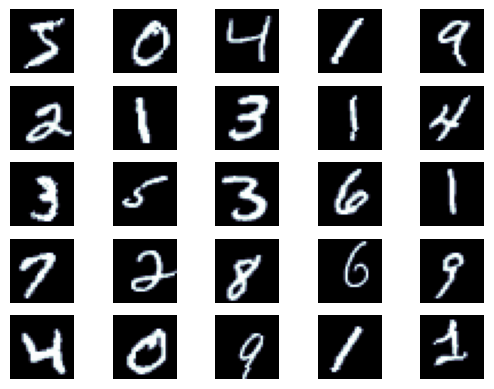

In [9]:
N_IMAGES = 25

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]

plot_images(images)

In [10]:
## Create Validation Set

VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])

print(f'Number of training examples : {len(train_data)}')
print(f'Number of validation examples : {len(valid_data)}')
print(f'Number of testing examples : {len(test_data)}')

Number of training examples : 54000
Number of validation examples : 6000
Number of testing examples : 10000


### Validation dataset transforms

- Validation dataset 의 transforms 은 test set 과 동일하다. 이때 이를 적용할 때 valid_data 에 바로 적용하면 train_dataset의 transforms 까지 변경되므로 이를 방지하기 위해서 deepcopy 를 하여 분리한다.



In [11]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transform

In [12]:
## Data Loaders 생성

BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                 batch_size = BATCH_SIZE)


## Define Model

- 2개의 hidden layer 를 가지고 있는 MLP 모델을 만들도록 하겠다.

### 모델 구조

1. input layer : 1x28x28 - 784 element vector
2. hidden layer 1 : 784 -> 250
3. hidden layer 2 : 250 -> 100
4. output layer : 100 -> 10 dimensional vector

- 각각의 layer 들은 fully connected layer 또는 affine layer 로 구성되어 있다. 
- 첫번째 layer 를 통과하여 이미지가 flattend 되고, 두번째 layer 를 통과하면서 input들의 weighted sum 이 계산된다.
이후 activation function 인 ReLU 를 통과하개 된다.
- 세번째 layer 또한 weighted sum 을 계산하고, ReLU 를 통과하게 된다.
- 마지막 layers 는 10개의 class 에 대한 logit 을 출력하게 된다.

### Activation Function

- hidden layer 들은 ReLU activation function 을 사용하였다.
- output layer 는 logit 을 출력하기 때문에 activation function 을 사용하지 않았다.
- ReLU 는 다음과 같은 수식으로 정의된다.

$$
\text{ReLU}(x) = \max(0, x)
$$
- ReLU 는 유명한 non-linear function 이며, vanishing gradient problem 을 해결해준다.

> Activation FUnction 은 입력이나 출력에 사용하지 않는다. </br>
이는 PyTorch 출력에 적용할 활성화 함수를 신경망의 **손실** 을 계산하는 함수와 결합한다. 이는 수치적 안정성을 위해 수행된다.

### hidden layer 의 차원 선택
- 일반적으로 신경망을 구성하는 아이디어는 신경망이 데이터에서 feature 를 추출한다는 것이다. </br>
입력에 더 가까운 레이어는 일반적인 피처(선, 곡선, 모서리)를 추출하는 법을 배우고, 이후 레이어는 이전 레이어에서 추출한 피처를 결합하여 더 높은 수준의 피처(두 선의 교차로, 여러 곡선이 원을 만든다.)를 만든다.
- 따라서 우리는 각 계층의 뉴런 수를 적절히 줄임으로써 신경망의 이러한  특징을 학습하도록 강제한다. 이런 방식으로 유용하고 일반적인 특징만 추출하여 정보를 압축하는 법을 배워야 한다.
- 이는 여러 계층과, 어떤 종류의 정보 압축(후속 계층의 뉴런 수 감소)이 있는 신경망이 필요하다.

In [13]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100,output_dim)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        h_1 = F.relu(self.input_fc(x))
        h_2 = F.relu(self.hidden_fc(h_1))
        y_pred = self.output_fc(h_2)

        return y_pred, h_2
    
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10

model = MLP(INPUT_DIM, OUTPUT_DIM)

- 여기서 y_pred, h_2 두가지를 return 한 이유는 추후에 h_2 층과 최종 output 층을 비교해보기 위해서 이다.
- 원래는 y_pred만 return 해도 무방하다.

- return 은 무조건 최종적인걸 해줘야 하나 그 이후에 다른걸 추가해도 상관은 없는듯하다

- 파라미터 수

$$784 \cdot 250 + 250 + 250 \cdot 100 + 100 + 100 \cdot 10 + 10 = 222,360 $$

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 222,360 trainable parameters


## Training Model

- 학습 과정
    - data 의 loss 를 계산하고 이를 통해 gradient 를 계산한 뒤 optimizer 를 통해 parameter 를 업데이트 한다.

- 데이터를 batch 단위로 model 에 통과시킨다.
- 실제 데이터와 예측한 데이터의 loss 를 계산한다.
- loss 를 통해 gradient 를 계산한다.
- optimizer 를 통해 parameter 를 업데이트 한다.

In [15]:
optimizer = optim.Adam(model.parameters())

#### define loss function(crierion)

- `CrossEntropyLoss` : multi-class classification 문제에서 사용하는 loss function
    - softmax activation function을 적용한 후, cross entropy loss를 계산한다.

Then, we define a *criterion*, PyTorch's name for a loss/cost/error function. This function will take in your model's predictions with the actual labels and then compute the loss/cost/error of your model with its current parameters.

`CrossEntropyLoss` both computes the *softmax* activation function on the supplied predictions as well as the actual loss via *negative log likelihood*. 

Briefly, the softmax function is:

$$\text{softmax }(\mathbf{x}) = \frac{e^{x_i}}{\sum_j e^{x_j}}$$ 

This turns out 10 dimensional output, where each element is an unbounded real number, into a probability distribution over 10 elements. That is, all values are between 0 and 1, and together they all sum to 1. 

Why do we turn things into a probability distribution? So we can use negative log likelihood for our loss function, as it expects probabilities. PyTorch calculates negative log likelihood for a single example via:

$$\text{negative log likelihood }(\mathbf{\hat{y}}, y) = -\log \big( \text{softmax}(\mathbf{\hat{y}})[y] \big)$$

$\mathbf{\hat{y}}$ is the $\mathbb{R}^{10}$ output, from our neural network, whereas $y$ is the label, an integer representing the class. The loss is the negative log of the class index of the softmax. For example:

$$\mathbf{\hat{y}} = [5,1,1,1,1,1,1,1,1,1]$$

$$\text{softmax }(\mathbf{\hat{y}}) = [0.8585, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157]$$

If the label was class zero, the loss would be:

$$\text{negative log likelihood }(\mathbf{\hat{y}}, 0) = - \log(0.8585) = 0.153 \dots$$

If the label was class five, the loss would be:

$$\text{negative log likelihood }(\mathbf{\hat{y}}, 5) = - \log(0.0157) = 4.154 \dots$$

So, intuitively, as your model's output corresponding to the correct class index increases, your loss decreases.

In [16]:
criterion = nn.CrossEntropyLoss()

In [17]:
### device 정의

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [18]:
print(device)

mps


In [19]:
model = model.to(device)
criterion = criterion.to(device)

In [20]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [21]:
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc='Training', leave=False):
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [25]:
def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():
        for (x,y) in tqdm(iterator, desc = 'Evaluating', leave=False):
            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)



In [26]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [27]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'mlp-model.pt')
    
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 8s
	Train Loss: 0.172 | Train Acc: 94.72%
	 Val. Loss: 0.114 |  Val. Acc: 96.22%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 8s
	Train Loss: 0.135 | Train Acc: 95.77%
	 Val. Loss: 0.093 |  Val. Acc: 97.05%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 8s
	Train Loss: 0.119 | Train Acc: 96.35%
	 Val. Loss: 0.097 |  Val. Acc: 97.22%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 7s
	Train Loss: 0.107 | Train Acc: 96.68%
	 Val. Loss: 0.085 |  Val. Acc: 97.50%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 8s
	Train Loss: 0.100 | Train Acc: 96.89%
	 Val. Loss: 0.084 |  Val. Acc: 97.52%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 7s
	Train Loss: 0.092 | Train Acc: 97.08%
	 Val. Loss: 0.076 |  Val. Acc: 97.73%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 7s
	Train Loss: 0.088 | Train Acc: 97.18%
	 Val. Loss: 0.069 |  Val. Acc: 97.86%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 7s
	Train Loss: 0.083 | Train Acc: 97.49%
	 Val. Loss: 0.066 |  Val. Acc: 98.02%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 7s
	Train Loss: 0.080 | Train Acc: 97.52%
	 Val. Loss: 0.070 |  Val. Acc: 97.76%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 7s
	Train Loss: 0.078 | Train Acc: 97.57%
	 Val. Loss: 0.069 |  Val. Acc: 97.77%


In [28]:
model.load_state_dict(torch.load('./mlp-model.pt'))

test_loss , test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss : {test_loss:.3f} | Test Acc : {test_acc*100:.2f}%')

/var/folders/y7/gqrr888s3gj219stgv80ty2h0000gn/T/ipykernel_79020/3279647154.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./mlp-model

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss : 0.059 | Test Acc : 98.06%


In [28]:
%%writefile config.yml

SEED: 42
ROOT: './data'

VAL_RATIO: 0.1
BATCH_SIZE: 64

INPUT_DIM : 756
OUTPUT_DIM : 10

EPOCHS: 10

Overwriting config.yml


In [66]:
%%writefile data_loader.py

import torch
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import copy
import random
import os
        
class DataLoad:
    def __init__(self, ROOT, SEED, BATCH_SIZE, VAL_RATIO):
        self.ROOT = ROOT
        if not os.path.exists(ROOT):
            os.mkdir(ROOT)
        
        self.SEED = SEED
        self.BATCH_SIZE = BATCH_SIZE
        self.VAL_RATIO = VAL_RATIO
        self.dataload = self.load_data(self.ROOT,self.SEED, self.BATCH_SIZE, self.VAL_RATIO)


    def set_seed(self, SEED):    
        random.seed(SEED)
        np.random.seed(SEED)
        torch.manual_seed(SEED)
        torch.cuda.manual_seed(SEED)
        torch.backends.cudnn.deterministic = True

    def get_mean_std(self, ROOT):
        # Data Normalization
        # MNIST data load from local files
        temp_train_data = datasets.MNIST(root=ROOT,
                                    train=True,
                                    download=True,
                                    transform=transforms.ToTensor())

        MEAN = temp_train_data.data.float().mean() / 255
        STD = temp_train_data.data.float().std() / 255
        return MEAN, STD

    def load_data(self, ROOT, SEED, BATCH_SIZE, VAL_RATIO):
        self.set_seed(SEED)
        MEAN, STD = self.get_mean_std(ROOT)
            
        # Augmentation 정의
        train_transforms = transforms.Compose([
            transforms.RandomRotation(5, fill=(0,)),
            transforms.RandomCrop(28, padding=2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[MEAN], std=[STD])
        ])

        test_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[MEAN], std=[STD])
        ])

        ## Load DataSet
        train_data = datasets.MNIST(root=ROOT,
                                    train=True,
                                    download=True,
                                    transform=train_transforms)

        test_data = datasets.MNIST(root=ROOT,
                                train=False,
                                download=True,
                                transform=test_transforms)

        ## Split Train Validation


        n_train = int(len(train_data) * (1-VAL_RATIO))
        n_val = len(train_data) - n_train

        train_data, val_data = data.random_split(train_data, [n_train, n_val])

        val_data = copy.deepcopy(val_data)
        val_data.dataset.transform = test_transforms


        # Data Loaders

        train_iterator = data.DataLoader(train_data,
                                        shuffle=True,
                                        batch_size=BATCH_SIZE)

        valid_iterator = data.DataLoader(val_data,
                                        batch_size=BATCH_SIZE)

        test_iterator = data.DataLoader(test_data,
                                        batch_size=BATCH_SIZE)

        print(f"Train Data: {len(train_data)}")
        print(f"Validation Data: {len(val_data)}")
        print(f"Test Data: {len(test_data)}")
        
        return train_iterator, valid_iterator, test_iterator

Overwriting data_loader.py


In [67]:
%%writefile model.py

import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100,output_dim)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        h_1 = F.relu(self.input_fc(x))
        h_2 = F.relu(self.hidden_fc(h_1))
        y_pred = self.output_fc(h_2)

        return y_pred, h_2

Overwriting model.py


In [68]:
%%writefile trainer.py

import torch
import time

from data_loader import DataLoad

class Train:
    def __init__(self, model, optimizer, criterion, EPOCHS, config , train=True):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = torch.backends.mps.is_available() if 'mps' else 'cpu'
        self.epoch = EPOCHS
        data_load = DataLoad(config['ROOT'], config['SEED'], config['BATCH_SIZE'], config['VAL_RATIO'])
        self.train_iterator, self.valid_iterator, self.test_iterator = data_load
        if train:
            best_valid_loss = float('inf')

            for epoch in range(self.epoch):
                start_time = time.monotonic()
                
                train_loss, train_acc = self.train(model, self.train_iterator, optimizer, criterion, self.device)
                valid_loss, valid_acc = self.evaluate(model, self.valid_iterator, criterion, self.device)

                if valid_loss < best_valid_loss:
                    best_valid_loss = valid_loss
                    torch.save(model.state_dict(), 'mlp-model.pt')
                
                end_time = time.monotonic()

                epoch_mins, epoch_secs = self.epoch_time(start_time, end_time)

                print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
                print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
                print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
        else:
            self.evaluate(self.model, self.iterator, self.criterion)

    def calculate_accuracy(self, y_pred, y):
        top_pred = y_pred.argmax(1, keepdim=True)
        correct = top_pred.eq(y.view_as(top_pred)).sum()
        acc = correct.float() / y.shape[0]
        return acc

    def train(self, model, iterator, optimizer, criterion):
        epoch_loss = 0
        epoch_acc = 0

        model.train()

        for (x, y) in tqdm(iterator, desc='Training', leave=False):
            x = x.to(self.device)
            y = y.to(self.device)

            optimizer.zero_grad()

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)
            
            acc = calculate_accuracy(y_pred, y)

            loss.backward()

            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()

        return epoch_loss / len(iterator), epoch_acc / len(iterator)
    
    def evaluate(self, model, iterator, criterion):
        epoch_loss = 0
        epoch_acc = 0

        model.eval()

        with torch.no_grad():
            for (x,y) in tqdm(iterator, desc = 'Evaluating', leave=False):
                x = x.to(self.device)
                y = y.to(self.device)

                y_pred, _ = model(x)

                loss = criterion(y_pred, y)

                acc = calculate_accuracy(y_pred, y)

                epoch_loss += loss.item()
                epoch_acc += acc.item()

        return epoch_loss / len(iterator), epoch_acc / len(iterator)

    def epoch_time(self, start_time, end_time):
        elapsed_time = end_time - start_time
        elapsed_mins = int(elapsed_time / 60)
        elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
        return elapsed_mins, elapsed_secs

    

Overwriting trainer.py


In [69]:
%%writefile main.py

import torch
import torch.nn as nn
from data_loader import DataLoad
from model import MLP
from trainer import Train

import yaml

with open('config.yml') as f:
    config = yaml.safe_load(f)

model = MLP(config['INPUT_DIM'], config['OUTPUT_DIM'])
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

train = Train(model=model, optimizer=optimizer, criterion=criterion, train=True, EPOCHS=config['EPOCHS'], config = config)

Overwriting main.py


In [70]:
!python main.py

Train Data: 54000
Validation Data: 6000
Test Data: 10000
Traceback (most recent call last):
  File "/Users/minsu/Desktop/archive/DeepLearning/01_ImageClassification/1_MLP/main.py", line 17, in <module>
    train = Train(model=model, optimizer=optimizer, criterion=criterion, train=True, EPOCHS=config['EPOCHS'], config = config)
  File "/Users/minsu/Desktop/archive/DeepLearning/01_ImageClassification/1_MLP/trainer.py", line 15, in __init__
    self.train_iterator, self.valid_iterator, self.test_iterator = data_load
TypeError: cannot unpack non-iterable DataLoad object


In [ ]:
## This is Test